## Neural Network and Convolutional Neural Network Practice

In step 5, we want to add two more type functions into our program. 

First is optimization function. 
Previously, we apply stochastic gradient decent method (SGD) to adjust the weights and bias (training models). SGD is widely used by almost all machine learning models, however, there are more methods we can try to increase the training time, and get better model in some cases. 

Second, weight decay and dropout are two popular regularization methods to prevent overfitting in neural network models.

In [1]:
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

### Helper functions

In [2]:
def softmax(x):
    if x.ndim == 2:
        x = x.T # convert x_i from row to column
        x = x - np.max(x, axis = 0) # axis = 0: vertical 
        y = np.exp(x) / np.sum(np.exp(x), axis = 0)
        return y.T # transpose back to original format

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

# input type is one-hot-encoding label
def cross_entropy_error(y, t):
    delta = 1e-7
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y+delta)) / batch_size

### Layers

In [3]:
# forward: z = x if x > 0, 0 if x <= 0
# backward: df/dx = df/dz * dz/dx, 
# dz/dx = 1 if x > 0, 0 if x <= 0
class Relu():
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dfdz):
        out = dfdz.copy()
        out[self.mask] = 0
        return out

In [4]:
# forward: z = 1 / (1 + exp(-x) ) 
# backward: 
# dz/dx = z^2 * exp(-x) = 1/(1+exp(-x))^2 * exp(-x) 
#       = 1/(1+exp(-x)) * exp(-x)/(1+exp(-x)) 
#       = z * (1-z)
class Sigmoid():
    def __init__(self):
        self.out = None
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out
    def backward(self, dfdz):
        return dfdz * (1- self.out) * self.out

In [5]:
class Affine():
    def __init__(self, W, b):
        self.W, self.b = W, b
        self.x = self.dW = self.db = None
    
    def forward(self,x):
        self.x = x
        return np.dot(self.x, self.W) + self.b
    
    def backward(self,dfdy):
        dx = np.dot(dfdy, self.W.T)
        self.dW = np.dot(self.x.T, dfdy)
        self.db = np.sum(dfdy, axis = 0)
        return dx

In [6]:
class SoftmaxWithError():
    def __init__(self):
        self.error = None
        self.y_h = None
        self.y = None
    
    def forward(self, x, y):
        self.y = y
        self.y_h = softmax(x)
        self.error = cross_entropy_error(self.y_h, self.y)
        return self.error
    
    def backward(self):
        batch_data_size = self.y.shape[0]
        dx = (self.y_h - self.y) / batch_data_size
        return dx

### Optimization functions

#### Stochastic gradient decent (SGD):

$ W_{t+1} = W_t-\eta \frac{\partial Error}{\partial W_t}$

where $W_t$ are weights in step $t$, $\eta$ is learning rate, $Error$ is model predicted error.

#### Momentum
$v_t = \alpha v - \eta \frac{\partial Error}{\partial W_t}$

$ W_{t+1} = W_t + v_t$

Where $v_t$ is the velocity (in physical meaning), $\alpha$ is the fraction coefficient.

#### AdaGrad (RMSprop modified from AdaGrad)
$h_{t+1} = h_t + \frac{\partial Error}{\partial W_t} \odot \frac{\partial Error}{\partial W_t}$

$W_{t+1} = W - \eta \frac{1}{\sqrt{h}}\frac{\partial Error}{\partial W_t}$

Where $h$ is the sum of squre gradients. 

#### Adam (combine momentum and adaGrad)

In [7]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]

In [8]:
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.vel = None
        
    def update(self, params, grads):
        if self.vel is None: 
            self.vel = {} 
            for key, value in params.items():
                self.vel[key] = np.zeros_like(value)
                # zeros_like: Return an array of zeros with the same shape and type as a given array.
        for key in params.keys():
            self.vel[key] = self.momentum * self.vel[key] - self.lr * grads[key]
            params[key] += self.vel[key]

In [9]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, value in params.items():
                self.h[key] = np.zeros_like(value)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [10]:
class Adam:
    def __init__(self, lr = 0.01, beta1 = 0.9, beta2 = 0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, value in params.items():
                self.m[key], self.v[key] = np.zeros_like(value), np.zeros_like(value)
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter) 
        
        for key in params.keys():
            self.m[key] += (1.0 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1.0 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [11]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

### Visulization the differences between each optimizer

Here we use simple function to test our optimizers. We also predefine the gradient functions. 

$f(x,y) = \frac{x^2}{20}+y^2$

$\frac{df}{dx} = \frac{2x}{20} = \frac{x}{10}$

$\frac{df}{dy} = 2y$

In [12]:
# simple function, and the minimum is located at (x, y) = (0, 0)
def f(x, y):
    return x**2 / 20.0 + y**2
# gradient (differential equations)
def df(x, y):
    return x / 10.0, 2.0*y

In [26]:
# initial condition
init_x_y = (-10.0, 2.0)

# parameter and gradient dictionary
params = {}
grads = {}

In [27]:
optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.9)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

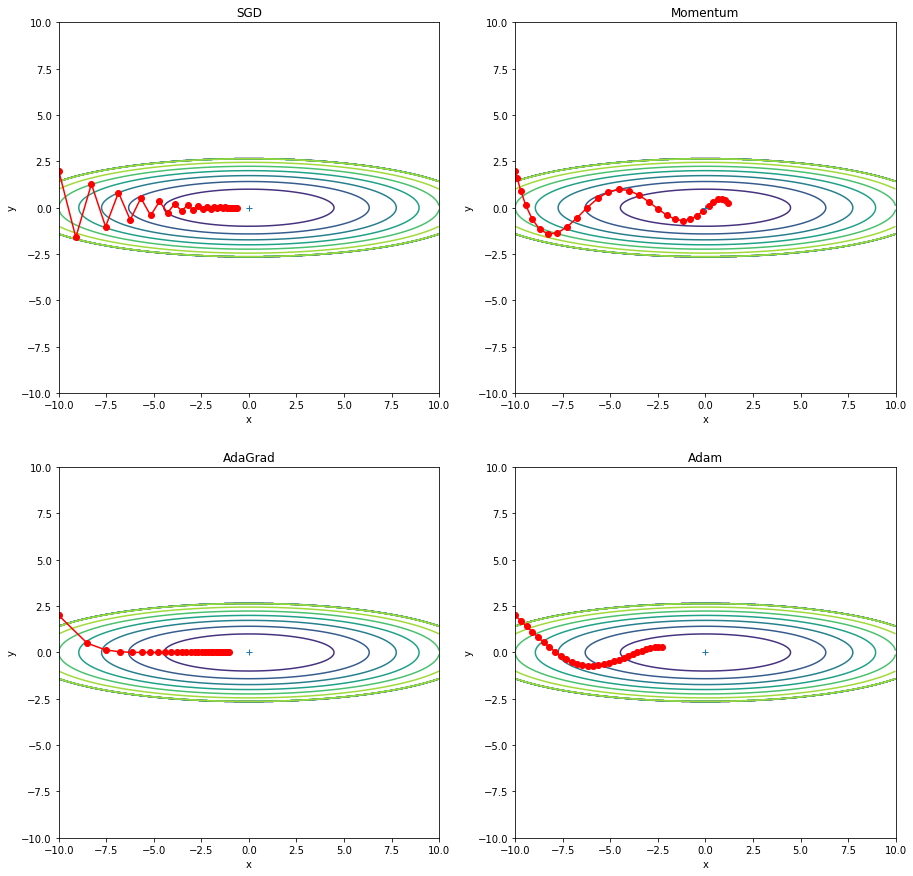

In [28]:
idx = 1
fig = plt.figure(figsize = (15,15))
for key in optimizers:
    optimizer = optimizers[key]
    x_log = []
    y_log = []
    params['x'], params['y'] = init_x_y[0], init_x_y[1]
    
    for i in range(30):
        x_log.append(params['x'])
        y_log.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_log, y_log, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

The example is borrowed from the textbook. If the learning rate is too large when using SGD method, the oscillation phenomena will happen, which means the weights are not modified efficiently (detour from initial point to center). Note, if the learning rate was set as 0.01, the SGD method will stock around the initial point. SGD cannot learn properly in that case. Momentum method slightly improves the oscillation issue and keeps the learning rate small enough. Adaptive gradient method (AdaGrad) applies learning rate decay idea to make the learning process from large step learning to small step learning. The position track looks perfect in this case. Note, the learning rate of AdaGrad will decrease to 0 with large enough iterations, weights will stop update in such case. RMSprop will fix this problem.  Adam is a combined method of Momentun and AdaGrad. The standard setting of $\beta_1$ and $\beta_2$ are 0.9 and 0.999.